# Regression Analysis

Regression analysis used to model the relationship between a dependent variable and one or more independent variables.  There are many different types of regression analysis that can be performed outside the common Linear and Logistic Regression methods.

## Simple Linear Regression or Ordinary Least Squares

Perhaps the most common and simplest of all the Regression techniques.  The formula is familar to anyone who has taken linear algebra classes.

\begin{align}y_i = \alpha + \beta x_i + \epsilon_i\end{align}

* y = the dependent variable or the variable you want to predict.  Also called the response variable.
* alpha = intercept
* beta = slope of the 
* x = the independent variable or in the case of time series, it's the time interval
* epsilon is the error which accounts for randomness that our model cannot explain.  This is also referred to
as the predictor or explanatory variable.

The information you are trying to predict y using function of x.

### Assumptions

* There is a linear relationship
* No multicollinearity (more important with multi predictor variables)
* Zero Conditional mean
* Homoskedasticity - variance is constant in residuals
* No autocorrelation

### Outliers

An outlier is a data point that lies far from the regression line, relative to the other data points. An outlier can sometimes have a significant effect on a regression analysis. We need to identify outliers and remove them from the analysis when appropriate (if we find that an outlier is a measurement or recording error).




In [32]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt
import seaborn as sns

%matplotlib inline

## Example

The example data is 1895 to 2017 average temperature for the US.

,Value,Anomaly
Date,,
1895,50.34,-3.29
1896,51.99,-1.64
1897,51.56,-2.07
1898,51.43,-2.20
1899,51.01,-2.62


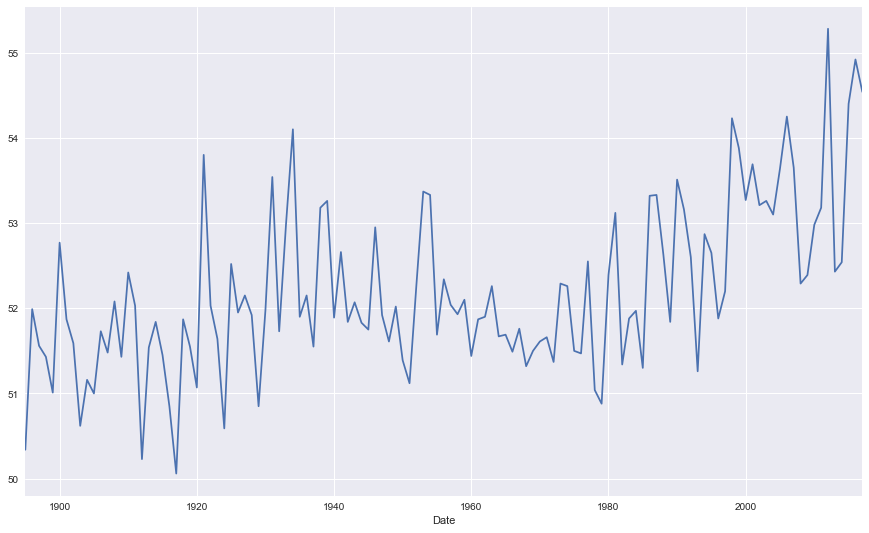

In [33]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
df = pd.read_csv('data/usweather.csv')
df['Date'] = [int(str(x)[0:4]) for x in df['Date']]
df = df.set_index('Date')
#df = df.iloc[-43:]
#df = pd.DataFrame({'bill': [34,108,64,88,99,51], 'Value': [5,17,11,8,14,5]})
#df = df.set_index('bill')
df['Value'].plot(ax=ax)
df.head()

### Solve for a and b

![title](images/linearregressionequations.bmp)

 

In [34]:
# solve for b
# b (coefficient) represents the change in the dependent variable resulting from 1 unit change by the predictor

sum_y = np.sum(df['Value'])
sum_x = np.sum(df.index.tolist())
sum_y2 = np.sum(df['Value']**2)
sum_x2 = np.sum([x **2 for x in df.index])
sum_xy = np.sum(df['Value'] * df.index.tolist())
n = len(df)

b = (n*sum_xy - sum_x * sum_y) / (n*sum_x2 - (sum_x ** 2))
b



0.015093446492337792

In [35]:
# solve for a
# y (intercept) represents the depentdent value when x is 0
a = (sum_y * sum_x2 - sum_x * sum_xy) / (n*sum_x2 - (sum_x ** 2))
a

22.679088579673117

In [36]:
# apply formula
# df['estimate'] = y
df['Estimate'] = [a + b * x for x in df.index] 

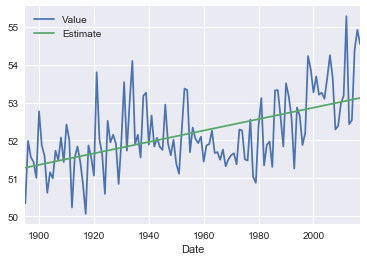

In [37]:
df[['Value', 'Estimate']].plot()

## Results

In the above chart, a simple regression line is displayed over the data.  The line can be compared to a trend for the data. There is a general upwards trend in average temperature over the last 100 or so years.

To validate the model, the residual errors need to be examined in time order.





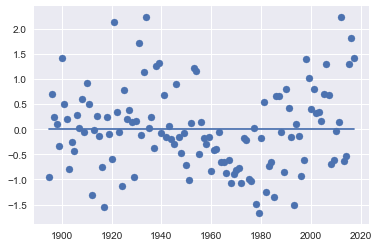

In [38]:
df['resids'] = df['Value'] - df['Estimate']
plt.scatter(df.index.tolist(), df['resids'].tolist())
plt.plot(df.index.tolist(), np.zeros(len(df)));



(<matplotlib.axes._subplots.AxesSubplot at 0x117ca1f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x116e042b0>)

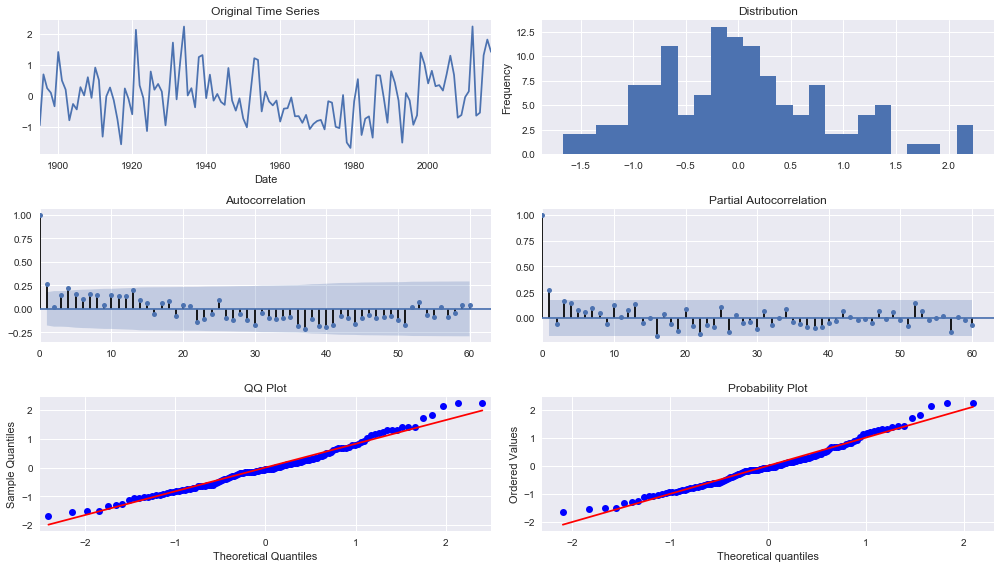

In [39]:
from helpers.time_series import tsplot
tsplot(df['resids'])

#### What to look for?

* The variance needs to be constant over time
* The residuals need to be normally distributed
* The residuals need to be random

__Original Time Series__

We can visualize the series to see that there is a mean of 0 and no change in variation for the residuals.  For
time series, the scatter plot and line chart can be used.

__Distribution__

Useful to check if the residuals are normally distributed (ideal is a bell curve). 

__Autocorellation__

No correlation (after 0) would indicate that the
residuals are random.

__Partial Autocorrelation__

Same as autocorrelation

__QQ Plot__

The QQ plot is a tool to assess the probability that the data came from a normal distribution.  By following along
a straight line, that would indicate that the values are normally distributed.

__Probability Plot__

Another tool to assess a normal distribution. For the most part, the normal P-P plot is better at finding deviations from normality in the center of the distribution, and the normal Q-Q plot is better at finding deviations in the tails.  Q-Q plots tend to be preferred in research situations.



### Model Checking

#### R-squared

R-squared is a measurement that takes the ratio of the model doesn't explain(differences between y and the estimate for y) and the total variation (y - the mean of y).

R-squared is a value between 0 and 1, with a score of 1 indicating that the model explains all the variability in the data. Generally, the higher the R-squared value the better.

**Note:**
Low values are not always bad.  It's possible to have a low R-squared value but still have statistically significant predictors.

Likewise a high R-squared doesn't always mean a good fit.  

In other words, R-squared is a good tool to use in combination with other result checking methods.

\begin{align} r^2 = \frac{SSR}{SST}\end{align}

#### Example

In [40]:
def r_squared(y_values, y_hat):
    mean_y = np.mean(y_values)
    SST = sum([(y - mean_y)**2 for y in y_values])
    #SSE = sum((y_values - y_hat)**2)
    SSR = sum([(y - mean_y)**2 for y in y_hat])
    return SSR / SST
    
print("The percent of variation of y explained by x: {0:.2f}%".format(r_squared(df['Value'], df['Estimate'])*100))


The percent of variation of y explained by x: 29.72%


#### Confindence interval

A confidence interval of the prediction is a range that is likely to contain the mean response given specified settings of the predictors in your model. Just like the regular confidence intervals, the confidence interval of the prediction presents a range for the coefficient rather than the distribution of individual data points.  

The interval is the probability that the sample coefficient is within a certain distance from the population coefficient not the probability that the population coefficient lies within the range.

First we need to calculate the standard error (aka Root Mean Square Error (RMSE)).



In [41]:
# find the standard error if the estimate
SE = np.sqrt(np.sum((df['Estimate'] - df['Value']) ** 2) / (len(df) - 2))
SE

0.83095417561704987

#### Interval estimate
![title](images/interval_estimate_regression.png)

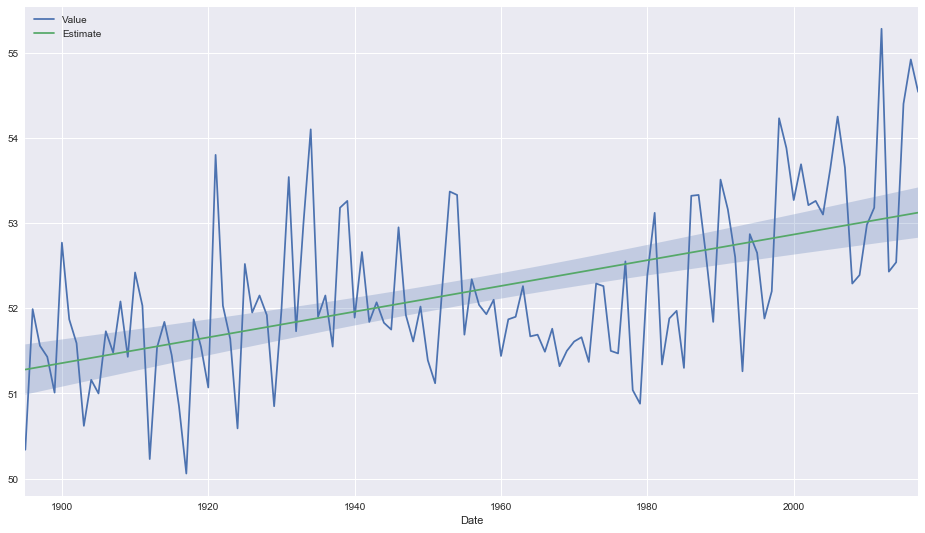

In [42]:
# construct 95% confidence interval
from scipy import stats

critical_t = stats.t.ppf(1-0.025, len(df) - 2)
mean_x = np.mean(df.index.values)
sum_x2 = np.sum([(x - mean_x)**2 for x in df.index.values])
df['ci_upper_bound'] = [(a + (b*x)) + critical_t * (SE * np.sqrt( (1 / len(df) + ((x - mean_x) **2 / sum_x2)))) for x in df.index]
df['ci_lower_bound'] = [(a + (b*x)) - critical_t * (SE * np.sqrt( (1 / len(df) + ((x - mean_x) **2 / sum_x2)))) for x in df.index]
fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)
ax.fill_between(df.index, df['ci_lower_bound'], df['ci_upper_bound'], alpha=.25)

df[['Value','Estimate']].plot(ax=ax)

## Prediction Interval

The confidence interval is for the mean value of the dependent variable where the prediction interval is for an 
individual value.

![title](images/prediction_interval_estimate.png)



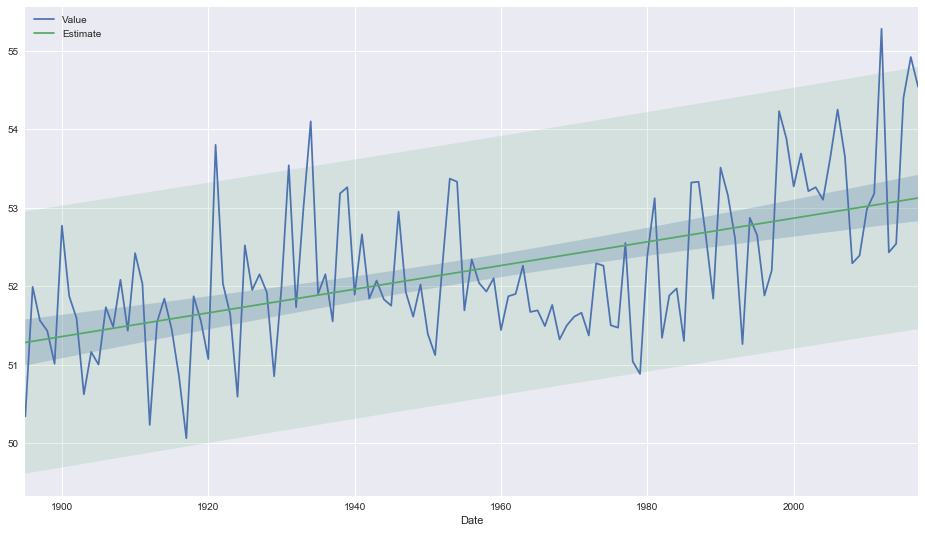

In [48]:

critical_t = stats.t.ppf(1-0.025, len(df) - 2)


df['pi_upper_bound'] = [(a + (b*x)) + critical_t * (SE * np.sqrt( (1 + (1 / len(df)) + ((x - mean_x) **2 / sum_x2)))) for x in df.index]
df['pi_lower_bound'] = [(a + (b*x)) - critical_t * (SE * np.sqrt( (1 + (1 / len(df)) + ((x - mean_x) **2 / sum_x2)))) for x in df.index]


fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)
ax.fill_between(df.index, df['ci_lower_bound'], df['ci_upper_bound'], alpha=.25)
ax.fill_between(df.index, df['pi_lower_bound'], df['pi_upper_bound'], alpha=.15)

df[['Value','Estimate']].plot(ax=ax)



Both the CI and PI bow slightly around the centroid (where the mean of x and the mean of y meet).  The predictions are at their most accurate when closer to the mean.

#### P-value

The p-value is used to check if the predictors being used are statistically significant.  The null hypothesis states that there isn't an effect between the dependent and independent variables.    The p-value is the probability of getting the test statistic if the null hypothesis is true.  The smaller the p=value, the greater the evidence is against the null hypothesis (the standards are to use < 0.05 or < 0.001).

Not everyone is a fan of p values because of fluctuation in values with different samples. People who argue against p-values, generally use bayesian methods to assess the goodness of fit.

In [13]:
# find the test statistic
#first find standard error
numerator = np.sum((1 / (len(df) - 2)) * np.sum((df['resids'] ** 2)))
mean_x = np.mean(df.index.tolist())
denominator = np.sum((df.index.tolist() - mean_x) **2)
Sx = np.sqrt(numerator / denominator)


t_stat = b/Sx #coefficient / standard error

#probability of t_stat
p = 2*(1-stats.t.cdf(np.abs(t_stat), len(df)-2))
p

7.0765393545002553e-11

## Simple Regression using sklearn

All the calculations were to establish an intuition on how simple linear regression works but there are numerous established classes/functions that hanlde the calculations for you.

Model slope:     [ 0.01509345]
Model intercept: [ 22.67908858]
Model score: 0.297164242206


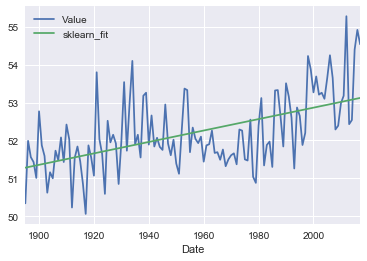

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
x = df.index.values.reshape(-1, 1)
y = df['Value'].values.reshape(-1, 1)
model.fit(x, y)

yfit = model.predict(x)
df['sklearn_fit'] = yfit
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)
print("Model score:", model.score(x, y))
df[['Value', 'sklearn_fit']].plot()

### Using statsmodel

Statsmodel also has a linear regression algorithm which also provides a summmary with information about the results of the regression estimation.

In [15]:
X = sm.add_constant(df.index.values)
model = sm.OLS(df['Value'].values, X)
reg = model.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     51.16
Date:                Fri, 22 Jun 2018   Prob (F-statistic):           7.08e-11
Time:                        10:52:45   Log-Likelihood:                -150.74
No. Observations:                 123   AIC:                             305.5
Df Residuals:                     121   BIC:                             311.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6791      4.128      5.494      0.000      14.506      30.852
x1             0.0151      0.002      7.153      0.000       0.011       0.019
==============================================================================
Omnibus:                        4.710   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.499
Skew:                           0.468   Prob(JB):                        0.105
Kurtosis:                       3.022   Cond. No.                     1.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Diagnostics


The __Durbin Watson__ test reports a test statistic, with a value from 0 to 4, where:

* 2 is no autocorrelation.
* 0 to 2 is positive autocorrelation (common in time series data).
* 2 to 4 is negative autocorrelation (less common in time series data).

__Skew__ is a measure of how symmetrical the data are; a skewed variable is one whose mean is not in the middle of the distribution (i.e., the mean and median are quite different)

+/- 3 would indicate the data isn't normally distributed

__Kurtosis__ has to do with how peaked the distribution is, either too peaked or too flat. 

+/- 3 would indicate the data isn't normally distributed




In [16]:
reg.pvalues


array([  2.21536451e-07,   7.07653147e-11])

In [17]:
reg.conf_int(alpha=0.025, cols=[1])

array([[ 0.01030405,  0.01988284]])

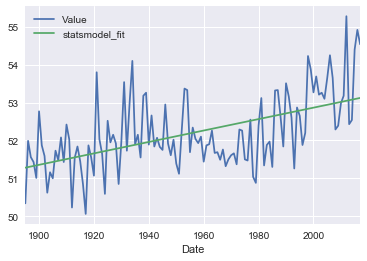

In [18]:
df['statsmodel_fit'] = reg.fittedvalues
df[['Value', 'statsmodel_fit']].plot()

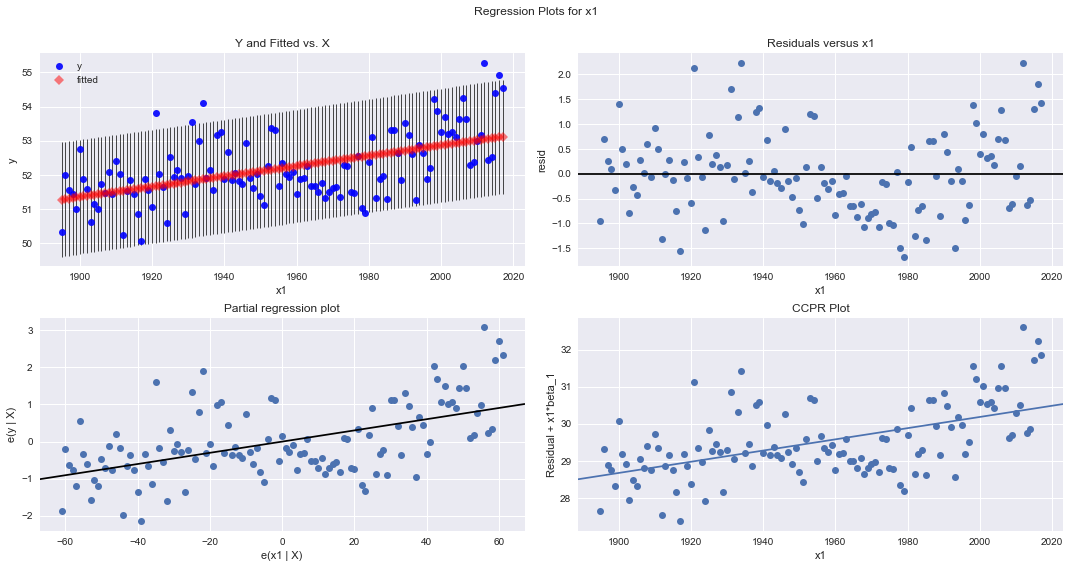

In [19]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(reg, "x1", fig=fig)

## Multiple Linear regression

\begin{align}Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_k x_k + \epsilon\end{align}

Multiple linear regression is an extension of simple linear regression.  Instead of having 1 independent and 1 depndent variable, multiple linear regression has 2 or more independent variables to explain/predict the variance in one dependent variable.

#### Additional Issues for MLR

__Overfitting__:  This is caused by added too many independent variables.

__Multicollinearity__:  This happens when 2 or more of the independent variables are correlated with each other.


For a good regression analysis, the analyst:

* Uses large amounts of trustworthy data and a small number of predictors that have well established causal relationships.
* Uses sound reasoning for including variables in the model.
* Brings together different lines of research as needed.
* Effectively presents the results using graphs, confidence intervals, and prediction intervals in a clear manner that ensures proper interpretation by others.

 


                            OLS Regression Results                            
Dep. Variable:                 murder   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     50.08
Date:                Fri, 22 Jun 2018   Prob (F-statistic):           3.42e-16
Time:                        10:52:46   Log-Likelihood:                -95.050
No. Observations:                  51   AIC:                             200.1
Df Residuals:                      46   BIC:                             209.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.1024     12.086     -3.649      0.0

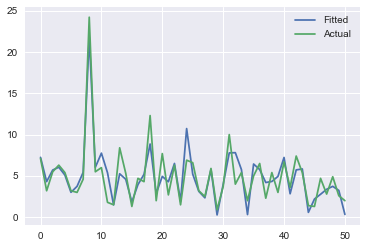

In [20]:
df = sm.datasets.statecrime.load_pandas()
model = sm.OLS(df.endog, sm.add_constant(df.exog))

reg = model.fit()
print(reg.summary())
plt.plot(range(0, 51), reg.fittedvalues, label="Fitted")
plt.plot(range(0, 51), df.endog.values, label="Actual")
plt.legend()


## Model Selection

Since the f-test is low, we can assume that at least one of our variables can be useful in estimating the murder rate.  Which one?  All of them?  We can begin test all the different combinations of variables and judge them by Akaike information criterion (AIC), Bayesian information criterion (BIC), and adjusted R2.

In [21]:
combos = [
    ['urban'],
    ['urban', 'poverty'],
    ['urban', 'hs_grad'],
    ['urban', 'single'],
    ['urban', 'poverty', 'hs_grad'],
    ['urban', 'poverty', 'single'],
    ['urban', 'hs_grad', 'single'],
    ['urban', 'poverty', 'hs_grad', 'single'],
    ['poverty'],
    ['poverty', 'hs_grad'], 
    ['poverty', 'single'], 
    ['poverty', 'hs_grad', 'single'], 
    ['hs_grad'], 
    ['hs_grad', 'single'],
    ['single']
]

df = sm.datasets.statecrime.load_pandas()

print("{} {} {} {} {:^6} {:^6} {:^6}".format("URBAN", "POVERTY", "HS_GRAD", "SINGLE", "AIC", "BIC", "R2"))
for c in combos:
    model = sm.OLS(df.endog, sm.add_constant(df.exog[c]))
    reg = model.fit()
    print("{:^5} {:^7} {:^7} {:^6} {:06.2f} {:06.2f} {:5.2f}".format("X" if "urban" in c else "", 
                                        "X" if "poverty" in c else "", 
                                        "X" if "hs_grad" in c else "", 
                                        "X" if "single" in c else "", 
                                        reg.aic, reg.bic, reg.rsquared_adj * 100))
    



URBAN POVERTY HS_GRAD SINGLE  AIC    BIC     R2  
  X                          274.94 278.80  7.01
  X      X                   249.98 255.77 44.05
  X              X           266.34 272.14 22.88
  X                     X    205.43 211.22 76.64
  X      X       X           250.36 258.09 44.64
  X      X              X    205.15 212.87 77.19
  X              X      X    206.88 214.61 76.40
  X      X       X      X    200.10 209.76 79.70
         X                   261.95 265.82 27.91
         X       X           263.45 269.25 27.13
         X              X    203.22 209.01 77.63
         X       X      X    198.65 206.38 79.92
                 X           267.67 271.53 19.36
                 X      X    206.43 212.23 76.18
                        X    204.82 208.69 76.48


The model with lowest AIC and BIC is using poverty, hs_grad, and single along with the highest adjusted r-squared.  The combination of those three variables would indicate the best model.  R-squared is preffered over regular r-squared in this case because the adjusted version penalizes for more parameters and allows to compare models with varying different numbers of variables.

This is one way of finding the best model but what if there were a large set of variables.  If there were 20 variables, there would be 2^20 (1048576) combinations.  This can get computationally expensive.  An alternative would to use Stepwise regression.  Variables are removed/added based on improvement to statistic significance. 

There are three models:

* __Foward Selection__:  Start with only an intercept and add each variable if significance improves.
* __Backward Elimination__: Start with all the variables and remove them one by one checking for loss of significance, keeping variables where there is a loss.
* __Bidirectional Elimination__: A combination of the two previous, testing each variable by including and excluding

Typically, the residual sum of squares (RSS) is used as a measure of significance, lower being better.

One criticism of this method are that tests are biased since they are based on the same data.  If there are a large amount of samples, cross validation can be used to remove bias.

#### Variable Elimination

Removing variables that are highly correlated can assist in model significance.  By plotting the distributions and correlation using a pair plot, you can see the variables relationships with each other.  Unexpected relationships may exist that would justify removing (or adding) variables.

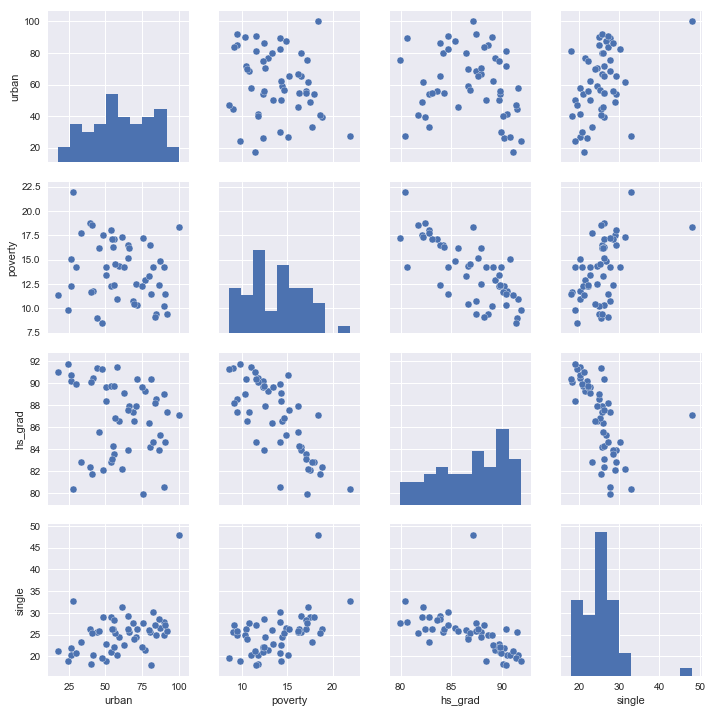

In [22]:
sns.pairplot(df.exog);

## Dummy Variables

Dummy variables (or categorical variables) are used to work with non-numeric data.   They can also be used to handle seasonal data.  In the IL weather data, using a simple linear regression yields an r-squared of 0, which states that the termperature isn't a function of time.  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                  0.004764
Date:                Fri, 22 Jun 2018   Prob (F-statistic):              0.945
Time:                        14:43:09   Log-Likelihood:                -485.86
No. Observations:                 113   AIC:                             975.7
Df Residuals:                     111   BIC:                             981.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.1942      3.362     15.526      0.0

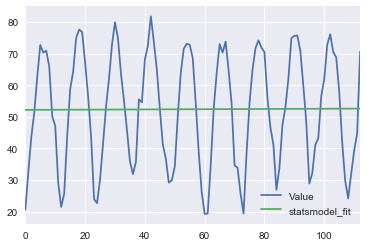

In [58]:
df = pd.read_csv('data/ilweather.csv')
#format date better
df['formatted_date'] = [pd.to_datetime(str(d) + str("01"), format="%Y/%m/%d") for d in df['Date']]
X = sm.add_constant(df.index.values)
model = sm.OLS(df['Value'].values, X)
reg = model.fit()
print(reg.summary())
df['statsmodel_fit'] = reg.fittedvalues
df[['Value', 'statsmodel_fit']].plot()

If we add categorie variables for the months, we can predict values using a seasonal coefficient.  N-1 variables are used because the last category will be a factor in the base coefficient.  The values encoded as 0s and 1s where 1 means categorical inclusive and 0 is categorical exclusion.

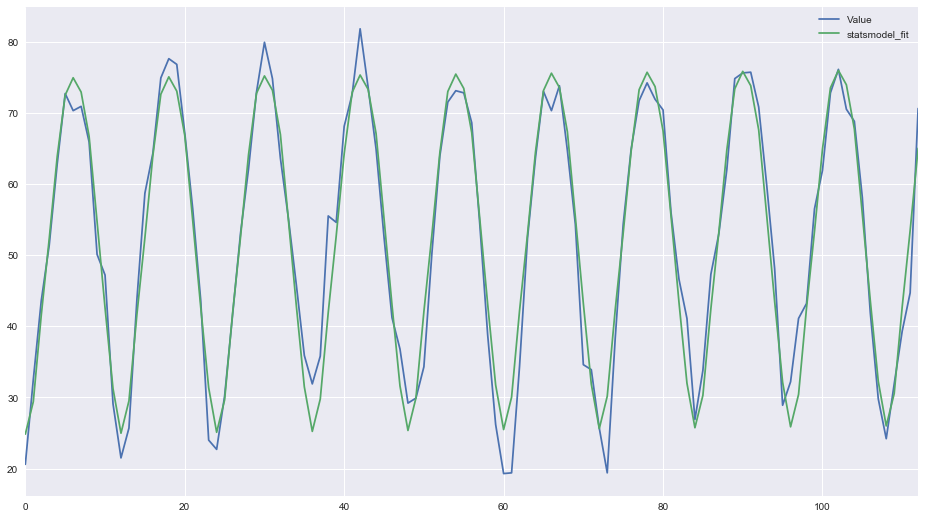

In [59]:
#add dummy variables
def generate_dummy(v, l):
    values = []
    month = 0
    for i in range(l):
        if v == month:
            values.append(1)
        else:
            values.append(0)
        month += 1
        if month >= 12:
            month = 0
    return values

df['X'] = df.index.values
df['jan'] = generate_dummy(0, len(df))
df['feb'] = generate_dummy(1, len(df))
df['mar'] = generate_dummy(2, len(df))
df['apr'] = generate_dummy(3, len(df))
df['may'] = generate_dummy(4, len(df))
df['jun'] = generate_dummy(5, len(df))
df['jul'] = generate_dummy(6, len(df))
df['aug'] = generate_dummy(7, len(df))
df['sep'] = generate_dummy(8, len(df))
df['oct'] = generate_dummy(9, len(df))
df['nov'] = generate_dummy(10, len(df))


#generate model
mod = sm.OLS(df['Value'], sm.add_constant(df[['X','jan', 'feb','mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']]))

reg = mod.fit()
reg.summary()
df['statsmodel_fit'] = reg.fittedvalues
fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)

df[['Value', 'statsmodel_fit']].plot(ax=ax)

    


In [25]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     153.1
Date:                Fri, 22 Jun 2018   Prob (F-statistic):           1.16e-58
Time:                        10:52:49   Log-Likelihood:                -318.39
No. Observations:                 113   AIC:                             662.8
Df Residuals:                     100   BIC:                             698.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.1143      1.612     19.306      0.000      27.917      34.312
X              0.0107      0.012      0.859      0.392      -0.014       0.035
jan           -6.2710      1.979     -3.169      0.002     -10.197      -2.345
feb           -1.7317      1.979     -0.875      0.384      -5.657       2.194
mar           10.4176      1.978      5.266      0.000       6.492      14.343
apr           21.1669      1.978     10.700      0.000      17.242      25.092
may           32.6962      1.978     16.529      0.000      28.772      36.621
jun           41.3085      2.031     20.341      0.000      37.279      45.338
jul           43.7423      2.030     21.544      0.000      39.714      47.771
aug           41.7205      2.030     20.551      0.000      37.693      45.748
sep           35.4987      2.030     17.489      0.000      31.472      39.526
oct           23.5103      2.030     11.584      0.000      19.484      27.537
nov           11.3662      2.029      5.601      0.000       7.340      15.393
==============================================================================
Omnibus:                        4.117   Durbin-Watson:                   1.295
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                5.010
Skew:                           0.080   Prob(JB):                       0.0817
Kurtosis:                       4.019   Cond. No.                         826.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

One-hot encoding is similar to using dummy variables except that instead of n-1 variables, n variables are used.  OHE is preferred offer dummy variables when an intercept (or constant) is not used.

## Interaction Term

When using multiple variables, there is a possibility that using a combination of variables produces a non-additive result.  In other words, the joint effect is higher then the sum of both effects. The non-interaction terms are referred to as the main effects.

For example, manufacturing plants that have workers and machines.  If you have a 1000 machines but zero workers or 1000 workers but zero machines, the productiity level is low.  But if you have 100 machines and 100 workers, the productivity level can be exponentially higher.

In that case, you would take the product of the two variables as a variable.

\begin{align}Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon\end{align}

To prove (or disprove) the single and hs_grad variables have a join effect, you can add the interaction term to the model.

In [26]:
df = sm.datasets.statecrime.load_pandas()
df.exog['interaction'] = df.exog['single'] * df.exog['hs_grad']
model = sm.OLS(df.endog, sm.add_constant(df.exog))

reg = model.fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 murder   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     39.45
Date:                Fri, 22 Jun 2018   Prob (F-statistic):           2.31e-15
Time:                        10:52:49   Log-Likelihood:                -94.914
No. Observations:                  51   AIC:                             201.8
Df Residuals:                      45   BIC:                             213.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -18.1462     54.351     -0.334      

The r-squared didn't change from the orignal results and the p-values all increased out of the 95% confidence level.  These results would show that the relationship between single and hs_grad is linear and not mutiplicative.

A good indicator for multiplicative relationships would be that the p-values are high for the main effect but the multiplicative relationship has a very low p-value.

Interaction variables can also be used on categorical variables by creating another dummy variable.  For instance, is a customer of type 'student' and a 'male'.

## Variance Inflation Factor (VIF)

VIF of the linear regression is defined as VIF = 1/T. With VIF > 10 there is an indication that multicollinearity may be present; with VIF > 100 there is certainly multicollinearity among the variables.



In [27]:
import statsmodels.stats.outliers_influence as ol
variables = reg.model.exog
vif = [ol.variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
v = pd.DataFrame({"name": reg.model.exog_names, "vif": vif})
v.head(12)

,name,vif
0,const,54903.953803
1,urban,2.081910
2,poverty,3.524737
3,hs_grad,78.261817
4,single,1741.218299
5,interaction,1423.002524


## Rolling window regression

This is a linear regression hack to deal with auto-correlated time series data.  If Xt is the current period, you could add a few dummy variables like Xt-1 amd Xt-2 to find how previous values effect the next value.

(<matplotlib.axes._subplots.AxesSubplot at 0x11851c1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118a903c8>)

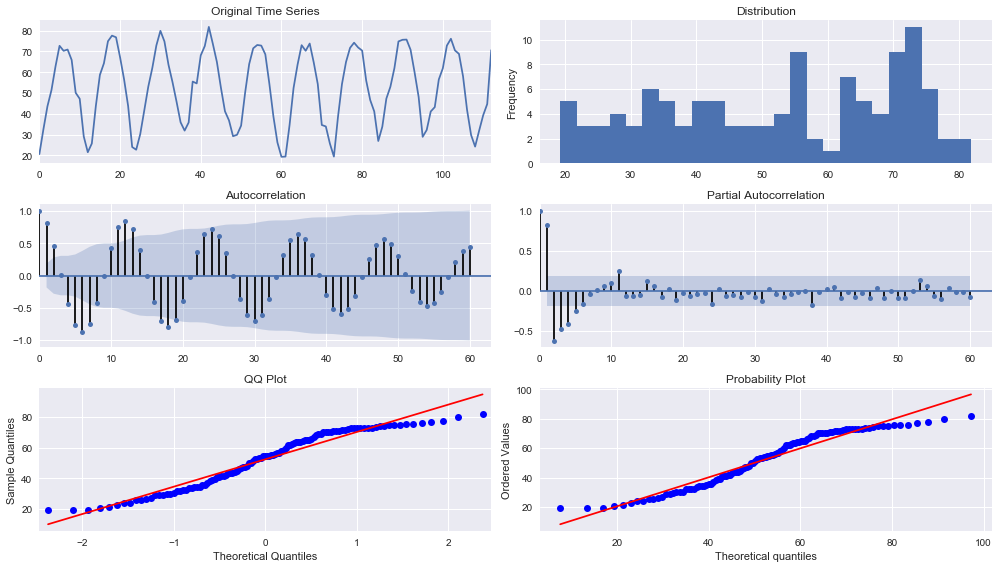

In [28]:
df = pd.read_csv('data/ilweather.csv')
#format date better
df['formatted_date'] = [pd.to_datetime(str(d) + str("01"), format="%Y/%m/%d") for d in df['Date']]
tsplot(df['Value'])

In [29]:
# The Autocorrelation chart can be used to select the number of shifts to use in order to see how minimize the error 
# Shift data
df['xt-1'] = df['Value'].shift()
df['xt-2'] = df['xt-1'].shift()
df['xt-3'] = df['xt-2'].shift()
df = df.dropna()
df.head(10)

,Date,Value,Anomaly,formatted_date,xt-1,xt-2,xt-3
3,200904,51.4,-2.4,2009-04-01,43.6,32.5,20.6
4,200905,62.8,-0.9,2009-05-01,51.4,43.6,32.5
5,200906,72.7,-0.3,2009-06-01,62.8,51.4,43.6
6,200907,70.3,-5.1,2009-07-01,72.7,62.8,51.4
7,200908,70.9,-2.5,2009-08-01,70.3,72.7,62.8
8,200909,65.9,-1.3,2009-09-01,70.9,70.3,72.7
9,200910,50.1,-5.1,2009-10-01,65.9,70.9,70.3
10,200911,47.2,4.1,2009-11-01,50.1,65.9,70.9
11,200912,29.1,-2.6,2009-12-01,47.2,50.1,65.9
12,201001,21.5,-4.1,2010-01-01,29.1,47.2,50.1


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     300.9
Date:                Fri, 22 Jun 2018   Prob (F-statistic):           1.08e-51
Time:                        10:54:14   Log-Likelihood:                -348.15
No. Observations:                 110   AIC:                             704.3
Df Residuals:                     106   BIC:                             715.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.3044      2.214     10.075      0.0

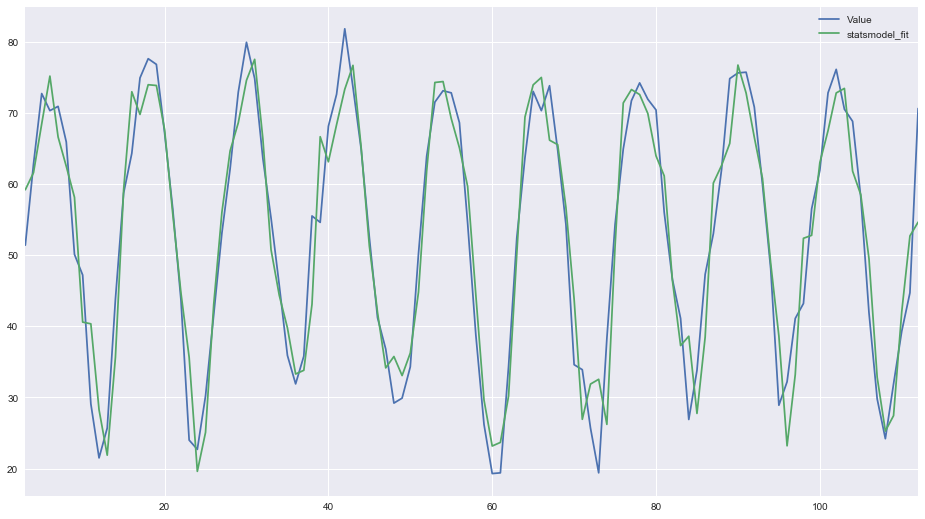

In [31]:
mod = sm.OLS(df['Value'], sm.add_constant(df[['xt-1', 'xt-2', 'xt-3']]))


reg = mod.fit()
print(reg.summary())
df['statsmodel_fit'] = reg.fittedvalues
fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)


df[['Value', 'statsmodel_fit']].plot(ax=ax)

## F-statistic

F-test and t-test are different ways of testing against the null hypothesis.   The main difference is that t-test is used comparing the means where f-test is comparing variances.  In general, f-test is preferred over t-test for MLR because it adjusts for the number of predictors. 

## Regularization

Regularization is used to help solve problems with a model overfitting by assigning a penalty term.  This is helpful with high multi-collinearity, large number of variables, and/or low ration of number of observations to number of variables.

There are two types of regularization.

#### L1 Loss or L1 Regularization

This adds a penalty term to the sum of the absolute values of coefficients.  Lasso regression typically uses L1 regularization.

#### L2 Loss or L2 Regularization

This adds a penalty term to the sum of the squares of coefficients.  Ridge regression typically uses L2 regularization.


#### Ridge Regression

Ridge regression helps with overfitting by minimizing the impact of irrelevant features.  This is helpful when variable elimination is not possible or practical.  

#### Lasso Regression

This method helps with overfitting as well.  The lasso method can zero out non relevant features and can reduce the number of features that was in the orignal set of features.  This method is also less affected by outliers then ridge regression is because of using absolute values instead of squaring the differences.

# Other Things

* Basis Function Regression
* Radial Basis Function Regression
* Passive Aggressive Algorithms
* Weighted Linear Regression
* Feature normalization (Example: MinMax scale)
* Trends can add correlation where there isn't any. Converting to log values or first differences could help the accuracy of the model. Time series
* transformation in regression - http://stattrek.com/regression/linear-transformation.aspx?Tutorial=AP - https://www.quora.com/What-are-some-common-transformations-I-can-make-in-univariate-regression
* standardized values
* https://www.r-bloggers.com/the-frisch-waugh-lovell-theorem-for-both-ols-and-2sls/
* http://blog.minitab.com/blog/adventures-in-statistics-2/proxy-variables-the-good-twin-of-confounding-variables




